# Решение спитцеровского уравнения теплопроводности плазмы

## Неявная разностная схема с нелинейностью на нижнем слое

Для численного решения задачи будем использовать неявную разностную схему с нелинейностью на нижнем слое

$$
\frac{y^{n+1}_{m} - y^{n}_{m}}{\tau} = \frac{1}{h}\left[k^n_{m + 1/2}\frac{y^{n+1}_{m+1} - y^{n+1}_{m}}{h} - k^n_{m - 1/2}\frac{y^{n+1}_{m} - y^{n+1}_{m - 1}}{h}\right] + f^n_m
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.pyplot import axes
#from celluloid import Camera

In [2]:
def qei(Te, Ti):
    if Te == 0:
        return 0.0
    else:
        return (Te - Ti) / Te ** 2

In [3]:
def k_12(y_m, y_m_1, alpha):
    return (y_m ** alpha + y_m_1 ** alpha) / 2

In [4]:
def u_init(x, To):
    u = np.zeros(x.size)
    for i in range(len(x)):
        if x[i] <= 1:
            u[i] = To
    return u

### Метод прогонки

#### Реализация метода

In [27]:
def make_diagonals(u1, u2, n, tau, h, M, mode='electrons'):
    # init variables
    a = np.zeros(M - 1)
    b = np.zeros(M)
    c = np.zeros(M - 1)
    d = np.zeros(M)
    sigma = tau / h ** 2
    u = u1[n, :] if mode == 'electrons' else u2[n, :]
    alpha = 2.5 if mode == 'electrons' else 1.5
    # first row
    c[0] = k_12(u[0], u[1], alpha) * sigma
    b[0] = 1 + c[0]
    d[0] = - (u[0] + qei(u1[n, 0], u2[n, 0]) * tau)
    # rows m = 2,...,M - 1
    for m in range(1, M - 1):
        a[m - 1] = k_12(u[m - 1], u[m], alpha) * sigma
        c[m] = k_12(u[m], u[m + 1], alpha) * sigma
        b[m] = 1 + a[m - 1] + c[m]
        d[m] = - (u[m] + qei(u1[n, m], u2[n, m]) * tau)
    # last row
    m = M - 1
    a[m - 1] = k_12(u[m - 1], u[m], alpha) * sigma
    b[m] = 1 + u[m] ** alpha + a[m - 1]
    d[m] = - (u[m] + qei(u1[n, m], u2[n, m]) * tau)
    return a, b, c, d

In [20]:
def thomas_solver(a, b, c, d):
    # init arrays
    M = len(b)
    u_sol = np.zeros(M)
    P = np.zeros(M)
    Q = np.zeros(M)
    # Forward first coefs
    P[0] = c[0] / b[0]
    Q[0] = - d[0] / b[0]
    # Forward coefs n = 1 ... M - 1
    for m in range(1, M - 1):
        P[m] = c[m] / (b[m] - a[m - 1] * P[m - 1])
        Q[m] = (a[m - 1] * Q[m - 1] - d[m]) / (b[m] - a[m - 1] * P[m - 1])
    #Forward last
    m = M - 1
    Q[m] = (a[m - 1] * Q[m - 1] - d[m]) / (b[m] - a[m - 1] * P[m - 1])

    # backward
    u_sol[-1] = Q[-1]
    for m in range(M - 1, -1, -1):
        u_sol[m - 1] = P[m - 1] * u_sol[m] + Q[m - 1]

    return u_sol

In [21]:
A = np.array([[11,4,0,0],
              [3,10,4,0],
              [0,1,7,5],
              [0,0,3,4]])
a = np.diag(A, -1)
b = np.diag(A)
c = np.diag(A, 1)
d = np.array([3, 4, 5, 6.])
print(np.linalg.solve(A, d))
print(thomas_solver(a, -b, c, d))

[-0.02367942  0.8151184  -1.02003643  2.26502732]
[-0.02367942  0.8151184  -1.02003643  2.26502732]


#### Применение метода

In [22]:
# Начальные значения
a = 0
b = 2
t_0 = 0
T = 0.01
To = 2

In [59]:
# Число узлов
N = 6000
M = 400

# Размер шага сетки
h = (b - a) / M
tau = (T - t_0) / N
print(f'{h=}, {tau=: .6f}')

print(f'sigma = {tau / h ** 2 * 0.5: .4f}')

h=0.005, tau= 0.000002
sigma =  0.0333


In [60]:
t = np.linspace(t_0, T, N)
x = np.linspace(a, b, M)

In [56]:
u1 = np.zeros((N + 1, M), dtype=np.double)
u1[0, :] = u_init(x, 2)

u2 = np.zeros((N + 1, M), dtype=np.double)
u2[0, :] = u_init(x, 2)

In [57]:
for n in tqdm(range(10)):
    a_e, b_e, c_e, d_e = make_diagonals(u1, u2, n, tau, h, M, mode='electrons')
    u1[n + 1, :] = thomas_solver(a_e, b_e, c_e, d_e)
    a_i, b_i, c_i, d_i = make_diagonals(u1, u2, n, tau, h, M, mode='ion')
    u2[n + 1, :] = thomas_solver(a_i, b_i, c_i, d_i)

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\aleks\AppData\Local\Temp\ipykernel_18952\445448729.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_m ** alpha + y_m_1 ** alpha) / 2


In [58]:
u1[:10, 400:]

array([[ 2.,  2.,  2., ...,  0.,  0.,  0.],
       [ 2.,  2.,  2., ...,  0.,  0.,  0.],
       [ 2.,  2.,  2., ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

#### Визуализация

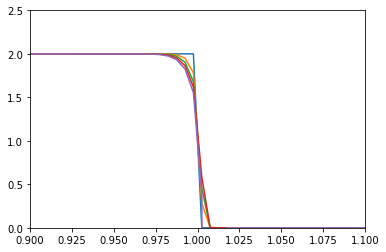

In [46]:
ax = axes(xlim=(0.9, 1.1), ylim=(0, 2.5))
for i in range(6):
    ax.plot(x, u1[i, :])
    #ax.plot(x, u2[i, :], color="red")

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import axes
from celluloid import Camera

fig = plt.figure()
camera = Camera(fig)
ax = axes(xlim=(0, 1.5), ylim=(0, 2.5))

for i in range(0, N, 20):
    ax.plot(x, u1[i, :], color="blue")
    ax.plot(x, u2[i, :], color="red")
    camera.snap()
animation = camera.animate()
animation.save('oh_my.gif', writer = 'imagemagick')

### Метод потоковой прогонки